Customer Columns: Index(['CustomerID', 'CustomerName', 'Region', 'SignupDate'], dtype='object')
  CustomerID        CustomerName         Region  SignupDate
0      C0001    Lawrence Carroll  South America  2022-07-10
1      C0002      Elizabeth Lutz           Asia  2022-02-13
2      C0003      Michael Rivera  South America  2024-03-07
3      C0004  Kathleen Rodriguez  South America  2022-10-09
4      C0005         Laura Weber           Asia  2022-08-15
Transactions Columns: Index(['TransactionID', 'CustomerID', 'ProductID', 'TransactionDate',
       'Quantity', 'TotalValue', 'Price'],
      dtype='object')
  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   
3        T00272      C0087      P067  2024-03-26 22:55:37         2   
4        T00363      C0070      

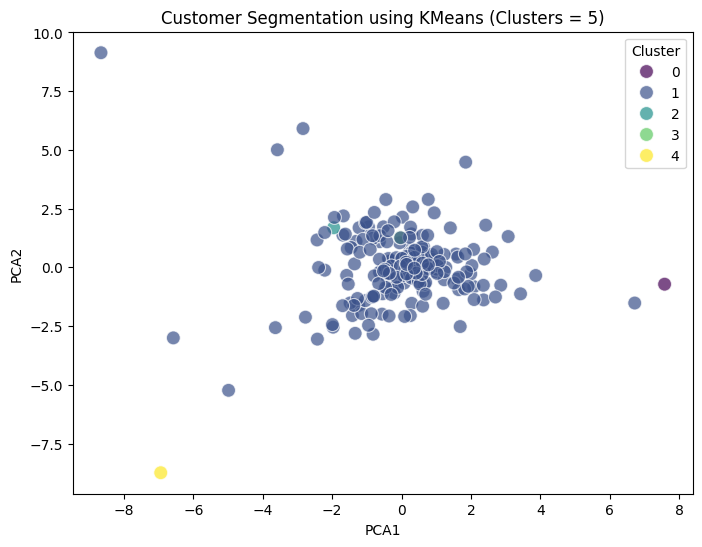


Customers in Cluster 0:
   CustomerID  Region
74      C0075  Europe

Customers in Cluster 1:
    CustomerID         Region
0        C0001  South America
1        C0002           Asia
2        C0003  South America
3        C0004  South America
4        C0005           Asia
..         ...            ...
195      C0196         Europe
196      C0197         Europe
197      C0198         Europe
198      C0199         Europe
199      C0200           Asia

[195 rows x 2 columns]

Customers in Cluster 2:
   CustomerID         Region
11      C0012  South America

Customers in Cluster 3:
    CustomerID Region
142      C0143   Asia

Customers in Cluster 4:
    CustomerID         Region
164      C0165  South America


In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Load customer and transaction data
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

# Check the columns to see which features are available in the data
print("Customer Columns:", customers.columns)
print(customers.head())
print("Transactions Columns:", transactions.columns)
print(transactions.head())

# Handle missing customer profile data (e.g., 'Age', 'Region' columns)
# Check if the necessary columns ('Age', 'Region') are available
if 'Age' in customers.columns:
    print("Age column found, proceeding with profile data.")
    customer_profile = customers[['CustomerID', 'Region', 'Age']]
else:
    print("Age column not found, using alternative columns.")
    customer_profile = customers[['CustomerID', 'Region']]  # Assuming 'Region' is available

# Handle missing values in the profile data
customer_profile = customer_profile.dropna(subset=['Region'])

# Encode categorical columns (e.g., 'Region')
customer_profile['Region_encoded'] = customer_profile['Region'].astype('category').cat.codes

# Scale the customer profile data
scaler = StandardScaler()
profile_scaled = scaler.fit_transform(customer_profile[['Region_encoded', 'Age']] if 'Age' in customer_profile else customer_profile[['Region_encoded']])

# Create a customer-product matrix from the transaction data
transaction_details = pd.merge(transactions, customers[['CustomerID']], on='CustomerID', how='left')
customer_product_matrix = transaction_details.pivot_table(index='CustomerID', columns='ProductID', values='Quantity', aggfunc='sum', fill_value=0)

# Scale the transaction data (customer-product matrix)
transaction_scaled = scaler.fit_transform(customer_product_matrix)

# Ensure the customer profile and transaction data have the same customers (same CustomerID)
# Align the customer profile data with the transaction data
customer_profile = customer_profile[customer_profile['CustomerID'].isin(customer_product_matrix.index)]

# Scale the aligned customer profile data
profile_scaled_aligned = scaler.fit_transform(customer_profile[['Region_encoded', 'Age']] if 'Age' in customer_profile else customer_profile[['Region_encoded']])

# Combine both customer profile and transaction data
combined_data = np.hstack([profile_scaled_aligned, transaction_scaled])

# Perform KMeans clustering (number of clusters chosen between 2 and 10, e.g., 5 clusters)
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(combined_data)

# Add cluster labels to the customers DataFrame
customers.loc[customers['CustomerID'].isin(customer_profile['CustomerID']), 'Cluster'] = clusters

# Evaluate clustering performance using Davies-Bouldin Index
db_index = davies_bouldin_score(combined_data, clusters)
print(f'Davies-Bouldin Index: {db_index:.4f}')

# Visualize the clusters using PCA (2D projection for visualization)
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(combined_data)

# Create a DataFrame for the reduced data and clusters
reduced_df = pd.DataFrame(reduced_data, columns=['PCA1', 'PCA2'])
reduced_df['Cluster'] = clusters

# Plot the clusters using seaborn scatterplot
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=reduced_df, palette='viridis', s=100, alpha=0.7)
plt.title(f'Customer Segmentation using KMeans (Clusters = {num_clusters})')
plt.show()

# Inspect the customers in each cluster
for cluster in range(num_clusters):
    print(f"\nCustomers in Cluster {cluster}:")
    print(customers[customers['Cluster'] == cluster][['CustomerID', 'Region']])

